In [77]:
import numpy as np
import matplotlib.pyplot as plt


def F(x, Xth, Xreset, tau):
    if x <= 0:
        return 0
    sqrt_x = np.sqrt(x)
    G_x = np.arctan(Xth / sqrt_x) - np.arctan(Xreset / sqrt_x)
    return sqrt_x  / (tau * G_x)
## QIFNeuron

class QIFNeuron:
    def __init__(self, tau, I_th, Xth, Xreset):
        self.tau = tau
        self.I_th = I_th
        self.Xth = Xth
        self.Xreset = Xreset
        self.X = Xreset
    
    def update(self, I_syn, I_stim, noise, dt):
        I_total = I_syn + I_stim + noise
        dX = (self.X ** 2 - self.I_th + I_total) * dt / self.tau
        self.X += dX
        #a = self.X
        if self.X >= self.Xth:
            self.X = self.Xreset
            return True
        return False

## calculation using approximation function

In [78]:
# calculation using approxiation function
class NeuronNetwork:
    def __init__(self, Ne, Ni, g_ee, g_ie, g_ei, g_ii, tau1_e, tau2_e, tau1_i, tau2_i, ith_e, ith_i, Xth, Xreset, tau):
        self.Ne = Ne
        self.Ni = Ni
        self.g_ee = g_ee
        self.g_ie = g_ie
        self.g_ei = g_ei
        self.g_ii = g_ii
        self.tau1_e = tau1_e
        self.tau2_e = tau2_e
        self.tau1_i = tau1_i
        self.tau2_i = tau2_i
        self.Xth = Xth
        self.Xreset = Xreset
        self.tau = tau
        self.exc_neurons = [QIFNeuron(tau, ith, Xth, Xreset) for ith in ith_e]
        self.inh_neurons = [QIFNeuron(tau, ith, Xth, Xreset) for ith in ith_i]
        self.S1_e = 2
        self.S2_e = 0
        self.S1_i = 2
        self.S2_i = 0
    
    def update_S(self, dt, spikes_e, spikes_i):
        #update synaptic variables
        self.S1_e += (spikes_e - (self.S1_e / self.tau1_e) * dt)
        self.S2_e += (spikes_e - (self.S2_e / self.tau2_e) * dt)
        self.S1_i += (spikes_i - (self.S1_i / self.tau1_i) * dt)
        self.S2_i += (spikes_i - (self.S2_i / self.tau2_i) * dt)
        

    def synaptic_current(self, neuron_type, i):
        #calculate synaptic current
        if neuron_type == 'E':            
            return (self.g_ee * (self.S1_e - self.S2_e)/ (self.tau1_e - self.tau2_e) + self.g_ei * (self.S1_i - self.S2_i) / (self.tau1_i - self.tau2_i))
        elif neuron_type == 'I':
            return (self.g_ie * (self.S1_e - self.S2_e)/ (self.tau1_e - self.tau2_e) + self.g_ii * (self.S1_i - self.S2_i) / (self.tau1_i - self.tau2_i))

    def simulate(self, I_stim_e, I_stim_i, dt, T):
        firing_rates_e = []
        firing_rates_i = []
        I_e = []
        I_i = []
        noise_std = 0.018  # Gaussian noise
        noise_mean = 0  

        for t in range(int(T / dt)):
            spikes_e = np.zeros(self.Ne)
            spikes_i = np.zeros(self.Ni)
            in_e = np.zeros(self.Ne)
            in_i = np.zeros(self.Ni)
            noise_e = np.random.normal(noise_mean, noise_std, self.Ne)
            noise_i = np.random.normal(noise_mean, noise_std, self.Ni)

            for i, neuron in enumerate(self.exc_neurons):
                I_syn = self.synaptic_current('E', i)
                i_t = I_syn + I_stim_e[t] + noise_e[i] - neuron.I_th
                spike = neuron.update(I_syn, I_stim_e[t], noise_e[i], dt)
                spikes_e[i] = spike
                in_e[i] = F(i_t, neuron.Xth, neuron.Xreset, neuron.tau)

            for i, neuron in enumerate(self.inh_neurons):
                I_syn = self.synaptic_current('I', i)
                i_t = I_syn + I_stim_i[t] + noise_i[i] - neuron.I_th
                spike = neuron.update(I_syn, I_stim_i[t], noise_i[i], dt)
                spikes_i[i] = spike
                in_i[i] = F(i_t, neuron.Xth, neuron.Xreset, neuron.tau)
            spike_e = np.sum(spikes_e)>0
            spike_i = np.sum(spikes_i)>0
            self.update_S(dt, spike_e, spike_i)
            
            fr_e = np.mean(in_e)
            fr_i = np.mean(in_i)

            firing_rates_e.append(fr_e*1000)
            firing_rates_i.append(fr_i*1000)

        return firing_rates_e, firing_rates_i

I_th distribution

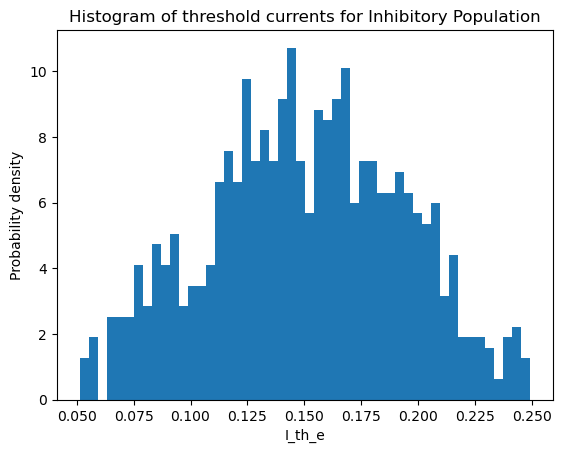

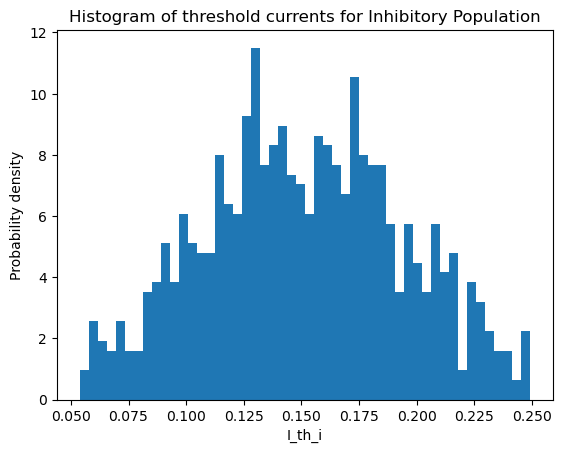

In [79]:
def draw_ith(n_samp: int, mean: float, std: float, rng: np.random.Generator):
    """Draw values according to a truncated normal distribution.
    Args:
    n_samp: number of samples
    mean: mean of the underlying normal distribution
    std: standard deviation of the underlying normal distribution
    rng: numpy random number generator
    Returns:
    the drawn values
    """
    ith_out = rng.normal(mean, std, size=n_samp)
    test_range = False
    while not test_range:
        mask = np.logical_or(ith_out < mean - 2 * std, ith_out > mean + 2 * std)
        n_update = np.sum(mask)
        ith_out[mask] = rng.normal(mean, std, size=n_update)
        test_range = not bool(np.sum(mask))
    return ith_out
rng = np.random.default_rng()
# Parameters
Ne = 800
Ni = 800
 
tau1_e = 1.0
tau2_e = 3.0
tau1_i = 1.0
tau2_i = 6.0
tau = 8.33
Xth = 1.3
Xreset = -1.3
mean_ith = 0.15
std_ith = 0.05
ith_e = draw_ith(Ne, mean_ith, std_ith, rng)
ith_i = draw_ith(Ni, mean_ith, std_ith, rng)

plt.hist(ith_e, bins=50, density=True)
plt.xlabel('I_th_e')
plt.ylabel('Probability density')
plt.title('Histogram of threshold currents for Inhibitory Population')
plt.show()
plt.hist(ith_i, bins=50, density=True)
plt.xlabel('I_th_i')
plt.ylabel('Probability density')
plt.title('Histogram of threshold currents for Inhibitory Population')
plt.show()


### dt = 0.5
g_ee = 17/100 \
g_ie = 16/100 \
g_ei = -1/800  \
g_ii = -2.75/800

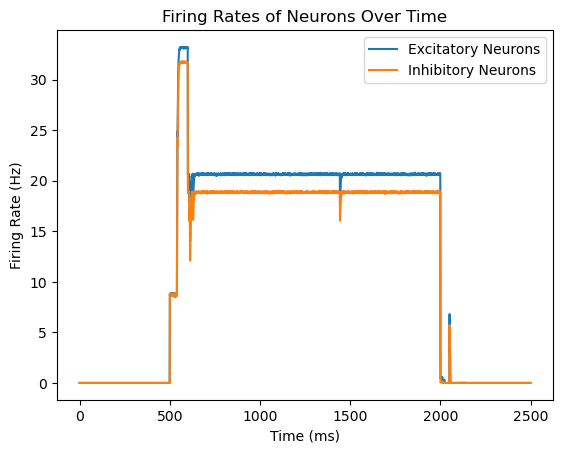

In [80]:

g_ee = 17/100
g_ie = 16/100 
g_ei = -1/800 
g_ii = -2.75/800
network = NeuronNetwork(Ne, Ni, g_ee, g_ie, g_ei, g_ii, tau1_e, tau2_e, tau1_i, tau2_i, ith_e, ith_i, Xth, Xreset, tau)

# stimulation
dt = 0.5
T = 2500
I_ext = np.zeros(int(T / dt))
stim_1_start = int(500 / dt)
stim_1_end = int(600 / dt)
stim_2_start = int(2000 / dt)
stim_2_end = int(2050 / dt)
I_ext[stim_1_start:stim_1_end] = 0.2
I_ext[stim_2_start:stim_2_end] = -.25

firing_rates_e, firing_rates_i = network.simulate(I_ext, I_ext, dt, T)

# plot
time = np.arange(0, T, dt)
plt.plot(time, firing_rates_e, label='Excitatory Neurons')
plt.plot(time, firing_rates_i, label='Inhibitory Neurons')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.title('Firing Rates of Neurons Over Time')
plt.show()

## calculation using spike count

In [74]:
# calculation using spike count
class NeuronNetwork:
    def __init__(self, Ne, Ni, g_ee, g_ie, g_ei, g_ii, tau1_e, tau2_e, tau1_i, tau2_i, ith_e, ith_i, Xth, Xreset, tau):
        self.Ne = Ne
        self.Ni = Ni
        self.g_ee = g_ee
        self.g_ie = g_ie
        self.g_ei = g_ei
        self.g_ii = g_ii
        self.tau1_e = tau1_e
        self.tau2_e = tau2_e
        self.tau1_i = tau1_i
        self.tau2_i = tau2_i
        self.Xth = Xth
        self.Xreset = Xreset
        self.tau = tau
        self.exc_neurons = [QIFNeuron(tau, ith, Xth, Xreset) for ith in ith_e]
        self.inh_neurons = [QIFNeuron(tau, ith, Xth, Xreset) for ith in ith_i]
        self.S1_e = 2
        self.S2_e = 0
        self.S1_i = 2
        self.S2_i = 0
    
    def update_S(self, dt, spikes_e, spikes_i):
        #update synaptic variables
        self.S1_e += (spikes_e - (self.S1_e / self.tau1_e) * dt)
        self.S2_e += (spikes_e - (self.S2_e / self.tau2_e) * dt)
        self.S1_i += (spikes_i - (self.S1_i / self.tau1_i) * dt)
        self.S2_i += (spikes_i - (self.S2_i / self.tau2_i) * dt)
        

    def synaptic_current(self, neuron_type, i):
        #calculate synaptic current
        if neuron_type == 'E':            
            return (self.g_ee * (self.S1_e - self.S2_e)/ (self.tau1_e - self.tau2_e) + self.g_ei * (self.S1_i - self.S2_i) / (self.tau1_i - self.tau2_i))
        elif neuron_type == 'I':
            return (self.g_ie * (self.S1_e - self.S2_e)/ (self.tau1_e - self.tau2_e) + self.g_ii * (self.S1_i - self.S2_i) / (self.tau1_i - self.tau2_i))

    def simulate(self, I_stim_e, I_stim_i, dt, T):
        firing_rates_e = []
        firing_rates_i = []
        I_e = []
        I_i = []
        noise_std = 0.018  # Gaussian noise
        noise_mean = 0  

        for t in range(int(T / dt)):
            spikes_e = np.zeros(self.Ne)
            spikes_i = np.zeros(self.Ni)
            in_e = np.zeros(self.Ne)
            in_i = np.zeros(self.Ni)
            noise_e = np.random.normal(noise_mean, noise_std, self.Ne)
            noise_i = np.random.normal(noise_mean, noise_std, self.Ni)

            for i, neuron in enumerate(self.exc_neurons):
                I_syn = self.synaptic_current('E', i)
                i_t = I_syn + I_stim_e[t] + noise_e[i] - neuron.I_th
                spike = neuron.update(I_syn, I_stim_e[t], noise_e[i], dt)
                spikes_e[i] = spike
                in_e[i] = F(i_t, neuron.Xth, neuron.Xreset, neuron.tau)

            for i, neuron in enumerate(self.inh_neurons):
                I_syn = self.synaptic_current('I', i)
                i_t = I_syn + I_stim_i[t] + noise_i[i] - neuron.I_th
                spike = neuron.update(I_syn, I_stim_i[t], noise_i[i], dt)
                spikes_i[i] = spike
                in_i[i] = F(i_t, neuron.Xth, neuron.Xreset, neuron.tau)
            spike_e = np.sum(spikes_e)>0
            spike_i = np.sum(spikes_i)>0
            self.update_S(dt, spike_e, spike_i)
            
            fr_e = np.mean(spikes_e)
            fr_i = np.mean(spikes_i)

            firing_rates_e.append(fr_e*1000/dt)
            firing_rates_i.append(fr_i*1000/dt)

        return firing_rates_e, firing_rates_i

### dt = 0.5
g_ee = 17/100 \
g_ie = 16/100 \
g_ei = -1/800  \
g_ii = -2.75/800

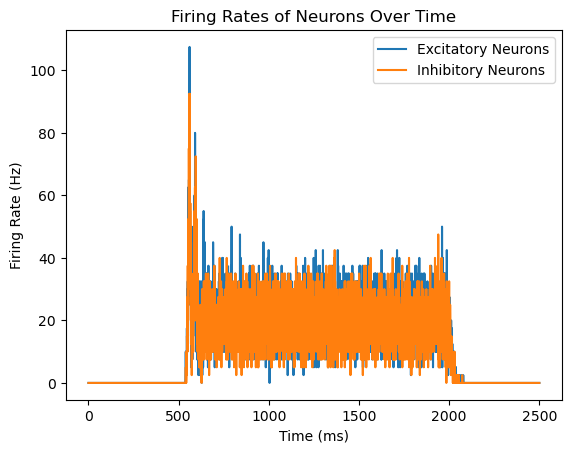

In [48]:

g_ee = 17/100 
g_ie = 16/100
g_ei = -1/800 
g_ii = -2.75/800
network = NeuronNetwork(Ne, Ni, g_ee, g_ie, g_ei, g_ii, tau1_e, tau2_e, tau1_i, tau2_i, ith_e, ith_i, Xth, Xreset, tau)

# stimulation
dt = 0.5
T = 2500
I_ext = np.zeros(int(T / dt))
stim_1_start = int(500 / dt)
stim_1_end = int(600 / dt)
stim_2_start = int(2000 / dt)
stim_2_end = int(2050 / dt)
I_ext[stim_1_start:stim_1_end] = 0.20
I_ext[stim_2_start:stim_2_end] = -.25

firing_rates_e, firing_rates_i = network.simulate(I_ext, I_ext, dt, T)

# plot
time = np.arange(0, T, dt)
plt.plot(time, firing_rates_e, label='Excitatory Neurons')
plt.plot(time, firing_rates_i, label='Inhibitory Neurons')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.title('Firing Rates of Neurons Over Time')
plt.show()

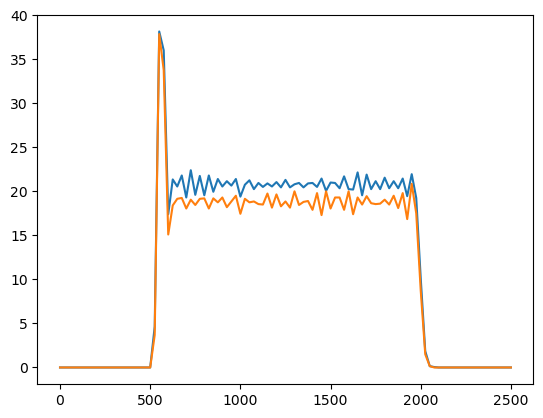

In [55]:
time = [i*25 for i in range(101)]
f_rate_e = [np.sum(firing_rates_e[i*50:(i+1)*50])/50 for i in range(101)]
f_rate_i = [np.sum(firing_rates_i[i*50:(i+1)*50])/50 for i in range(101)]
plt.plot(time,f_rate_e)
plt.plot(time,f_rate_i)
plt.show()

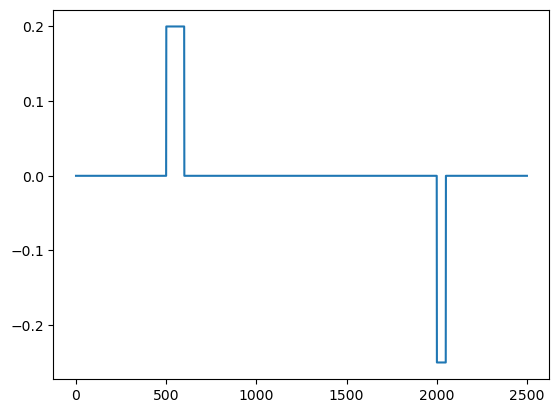

In [58]:
time = [i*0.5 for i in range(int(T/dt))]
plt.plot(time ,I_ext)

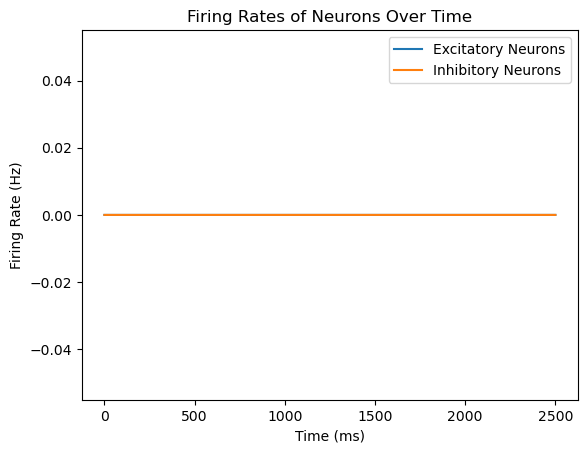

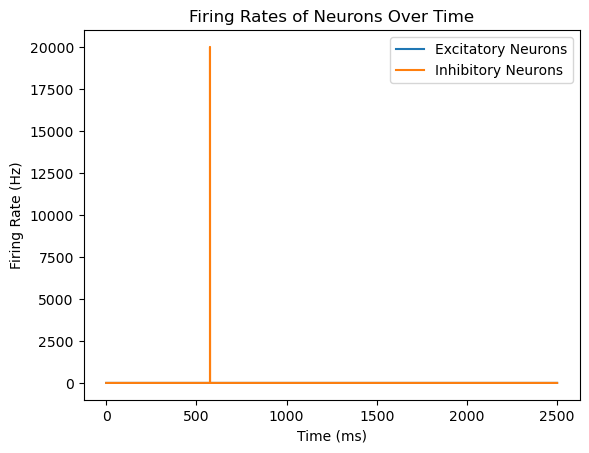

In [75]:
# Parameters
Ne = 1
Ni = 1
g_ee = 17 
g_ie = 16 
g_ei = -1.0 
g_ii = -2.75 
tau1_e = 1.0
tau2_e = 3.0
tau1_i = 1.0
tau2_i = 6.0
tau = 8.33
Xth = 1.3
Xreset = -1.3

mean_ith = 0.15
std_ith = 0.05
rng = np.random.default_rng()
ith_e = draw_ith(Ne, mean_ith, std_ith, rng)
ith_i = draw_ith(Ni, mean_ith, std_ith, rng)

network = NeuronNetwork(Ne, Ni, g_ee, g_ie, g_ei, g_ii, tau1_e, tau2_e, tau1_i, tau2_i, ith_e, ith_i, Xth, Xreset, tau)

# stimulating 
dt = 0.05
T = 2500
I_ext = np.zeros(int(T / dt))
stim_1_start = int(500 / dt)
stim_1_end = int(600 / dt)
stim_2_start = int(2000 / dt)
stim_2_end = int(2050 / dt)
# quiescent state
firing_rates_e, firing_rates_i = network.simulate(I_ext, I_ext, dt, T)

# plot
time = np.arange(0, T, dt)
plt.plot(time, firing_rates_e, label='Excitatory Neurons')
plt.plot(time, firing_rates_i, label='Inhibitory Neurons')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.title('Firing Rates of Neurons Over Time')
plt.show()

# with stimulation
I_ext[stim_1_start:stim_1_end] = .20
I_ext[stim_2_start:stim_2_end] = -.20

firing_rates_e, firing_rates_i = network.simulate(I_ext, I_ext, dt, T)

# plot
time = np.arange(0, T, dt)
plt.plot(time, firing_rates_e, label='Excitatory Neurons')
plt.plot(time, firing_rates_i, label='Inhibitory Neurons')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.title('Firing Rates of Neurons Over Time')
plt.show()


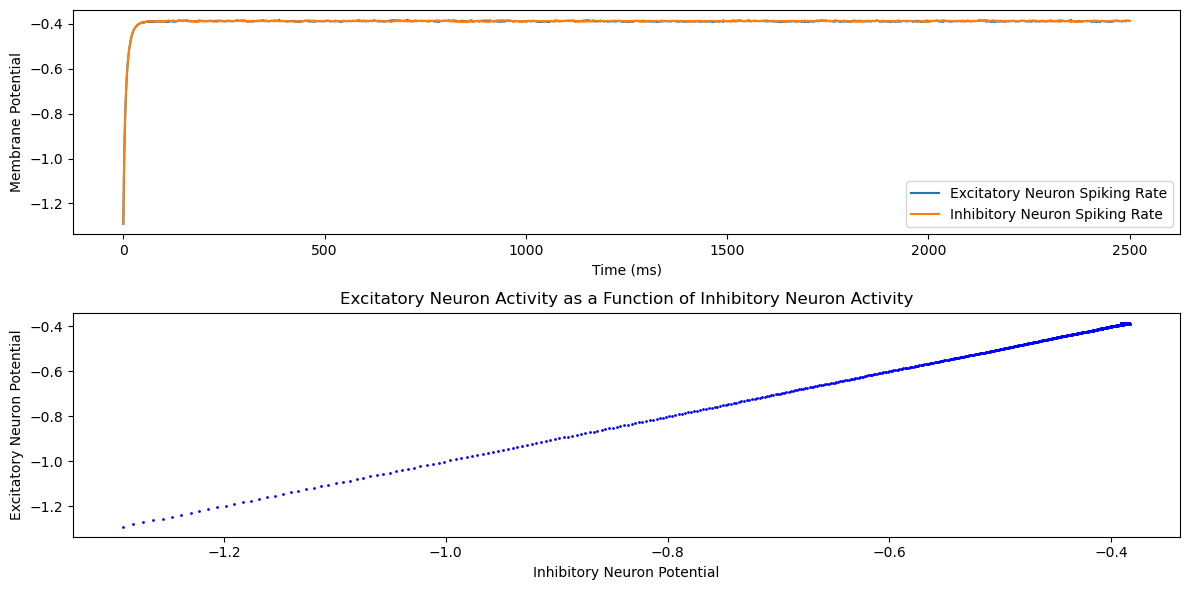

In [6]:
def synaptic_interaction(E_neuron, I_neuron, g_EI, g_IE, g_EE, g_II, tau1_e, tau2_e, tau1_i, tau2_i, dt):
    S1_e = 0
    S2_e = 0
    S1_i = 0
    S2_i = 0
    spikes_E = []
    spikes_I = []
    activities_E = []
    activities_I = []
    
    T = 2500
    for t in range(int(T / dt)):
        noise_E = np.random.normal(0, 0.018)
        noise_I = np.random.normal(0, 0.018)
        
        I_syn_E = g_EI * (S1_i - S2_i) / (tau1_i - tau2_i) + g_EE * (S1_e - S2_e) / (tau1_e - tau2_e)
        I_syn_I = g_IE * (S1_e - S2_e) / (tau1_e - tau2_e) + g_II * (S1_i - S2_i) / (tau1_i - tau2_i)
        
        spike_E = E_neuron.update(I_syn_E, 0, noise_E, dt)
        spike_I = I_neuron.update(I_syn_I, 0, noise_I, dt)
        
        S1_e += (spike_E - (S1_e / tau1_e) * dt)
        S2_e += (spike_E - (S2_e / tau2_e) * dt)
        S1_i += (spike_I - (S1_i / tau1_i) * dt)
        S2_i += (spike_I - (S2_i / tau2_i) * dt)
        
        spikes_E.append(spike_E)
        spikes_I.append(spike_I)
        activities_E.append(E_neuron.X)
        activities_I.append(I_neuron.X)
    
    return activities_E, activities_I, spikes_E, spikes_I

# Parameters
tau = 8.33
Xth = 1.3
Xreset = -1.3
I_th_E = 0.15
I_th_I = 0.15

# Synaptics connections
# here as we only have one ext neuron and one inh neuron
# only g_ei and g_ie exist
g_ei = -1.0 
g_ee = 18
g_ii = -2.75
g_ie = 16 
tau1_E = 1.0
tau2_E = 3.0
tau1_I = 1.0
tau2_I = 6.0

dt = 0.05

E_neuron = QIFNeuron(tau, I_th_E, Xth, Xreset)
I_neuron = QIFNeuron(tau, I_th_I, Xth, Xreset)

activities_E, activities_I, spikes_E, spikes_I = synaptic_interaction(E_neuron, I_neuron, g_ee, g_ie, g_ei, g_ii, tau1_E, tau2_E, tau1_I, tau2_I, dt)

time = np.arange(0, len(activities_E) * dt, dt)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, activities_E, label='Excitatory Neuron Spiking Rate')
plt.plot(time, activities_I, label='Inhibitory Neuron Spiking Rate')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(activities_I, activities_E, c='b', s=1)
plt.xlabel('Inhibitory Neuron Potential')
plt.ylabel('Excitatory Neuron Potential')
plt.title('Excitatory Neuron Activity as a Function of Inhibitory Neuron Activity')

plt.tight_layout()
plt.show()
